In [1]:
# basic bitches
import numpy as np
import pandas as pd
import datetime as dt
import missingno as msn

# preprocessing
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# model
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_curve, accuracy_score

# for pipeline
from create_labels import create_labels
from get_dummies import get_dummies
from keras_model import keras_model
from select_columns import select_columns
from sklearn.pipeline import Pipeline

# viz
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

% matplotlib inline

Using TensorFlow backend.


# Task 1

predictive_maintenance_dataset.csv is a file that contains parameters and settings: 
- operational_setting_1
- operational_setting_2
- sensor_measurement_1
- sensor_measurement_2
...            
for many wind turbines.        

There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. 

Your task is to create a model that, when fed with operational settings and sensor measurements (unit_number and time_stamp will not be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

In [2]:
df = pd.read_csv("../../data/predictive_maintenance_dataset.csv")
df.shape

(144203, 27)

In [3]:
df.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,133.75,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,522.19,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,163.11,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,130.58,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,519.44,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682


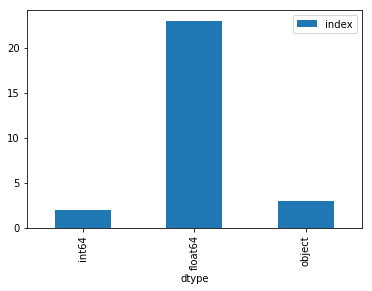

In [46]:
pd.DataFrame(df.dtypes.values, columns=['dtype']).reset_index().groupby('dtype').count().plot(kind='bar')

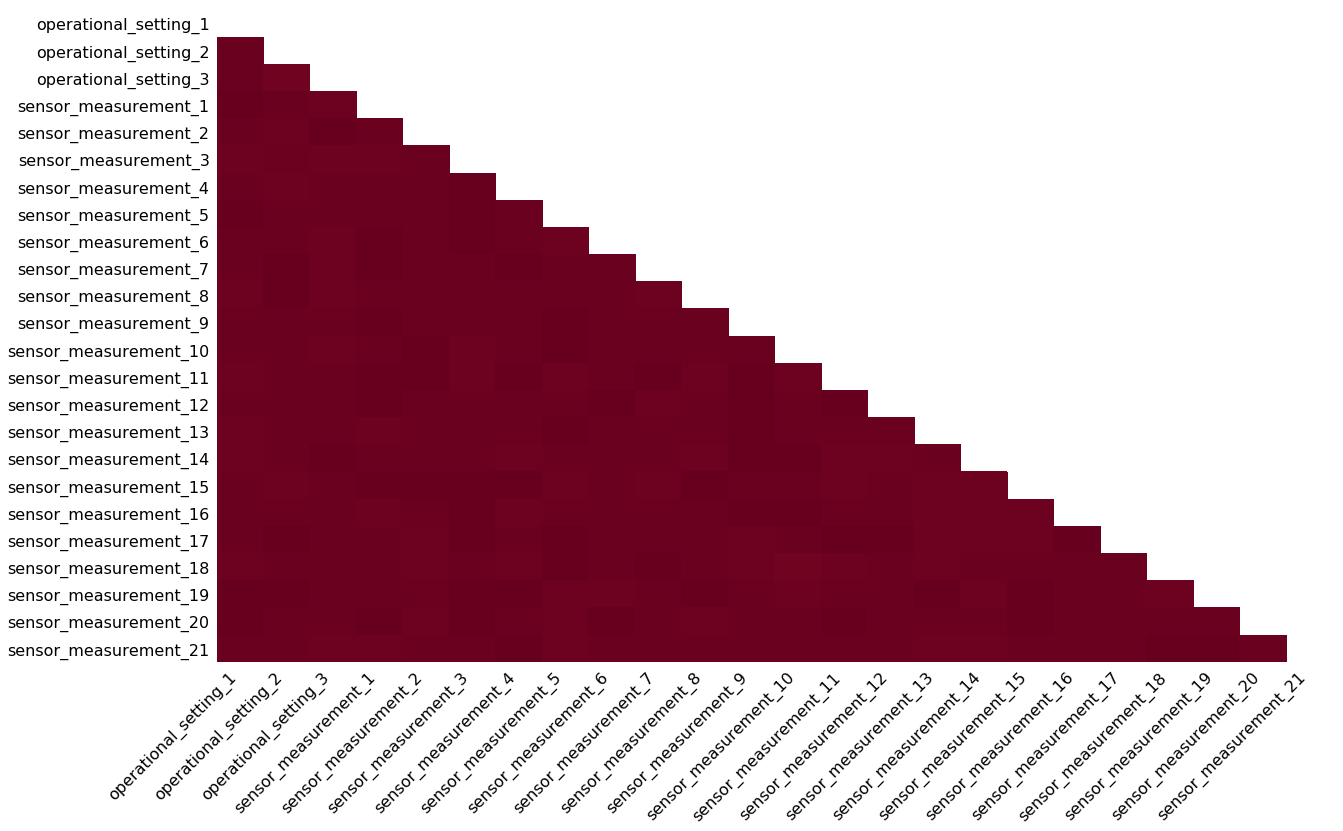

In [4]:
# Explore correlation
msn.heatmap(df)

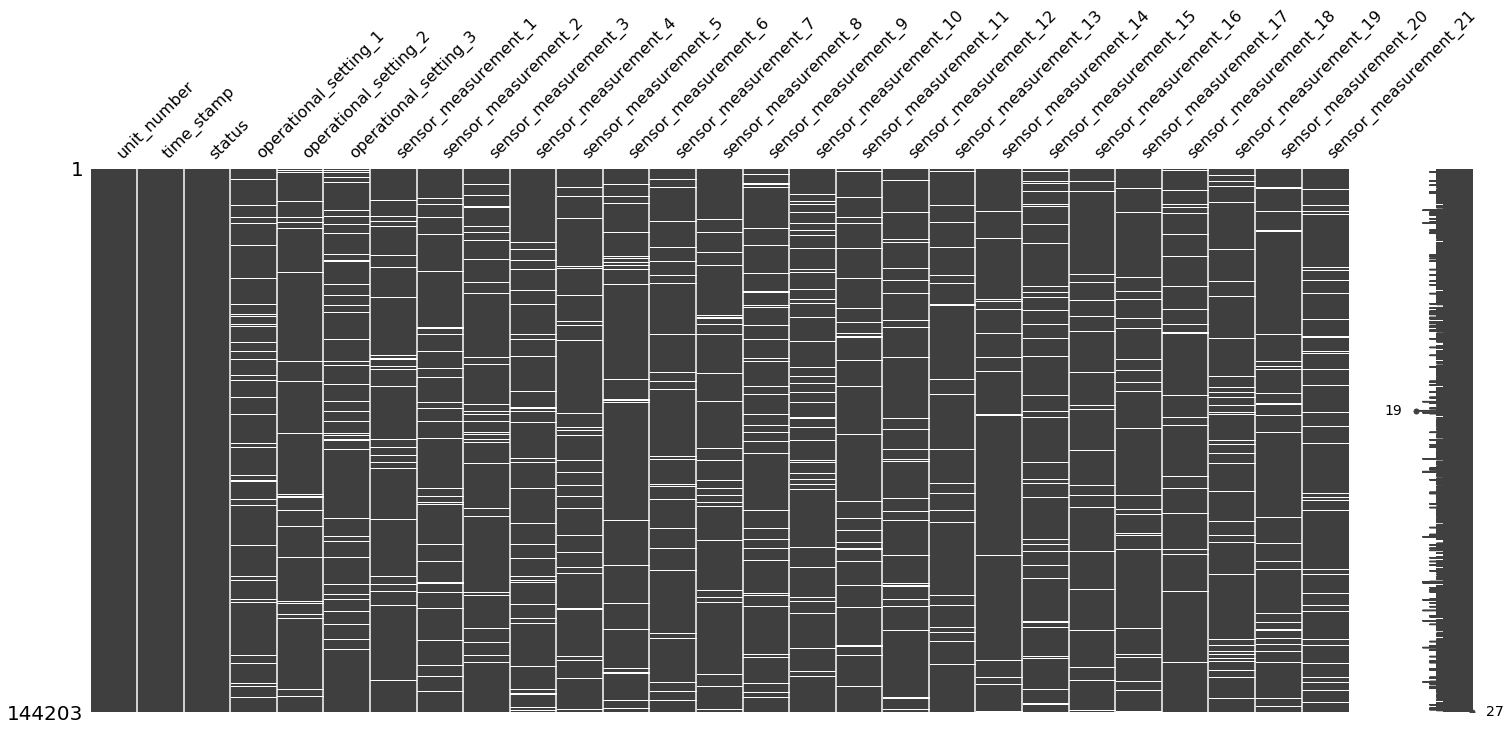

In [5]:
msn.matrix(df)

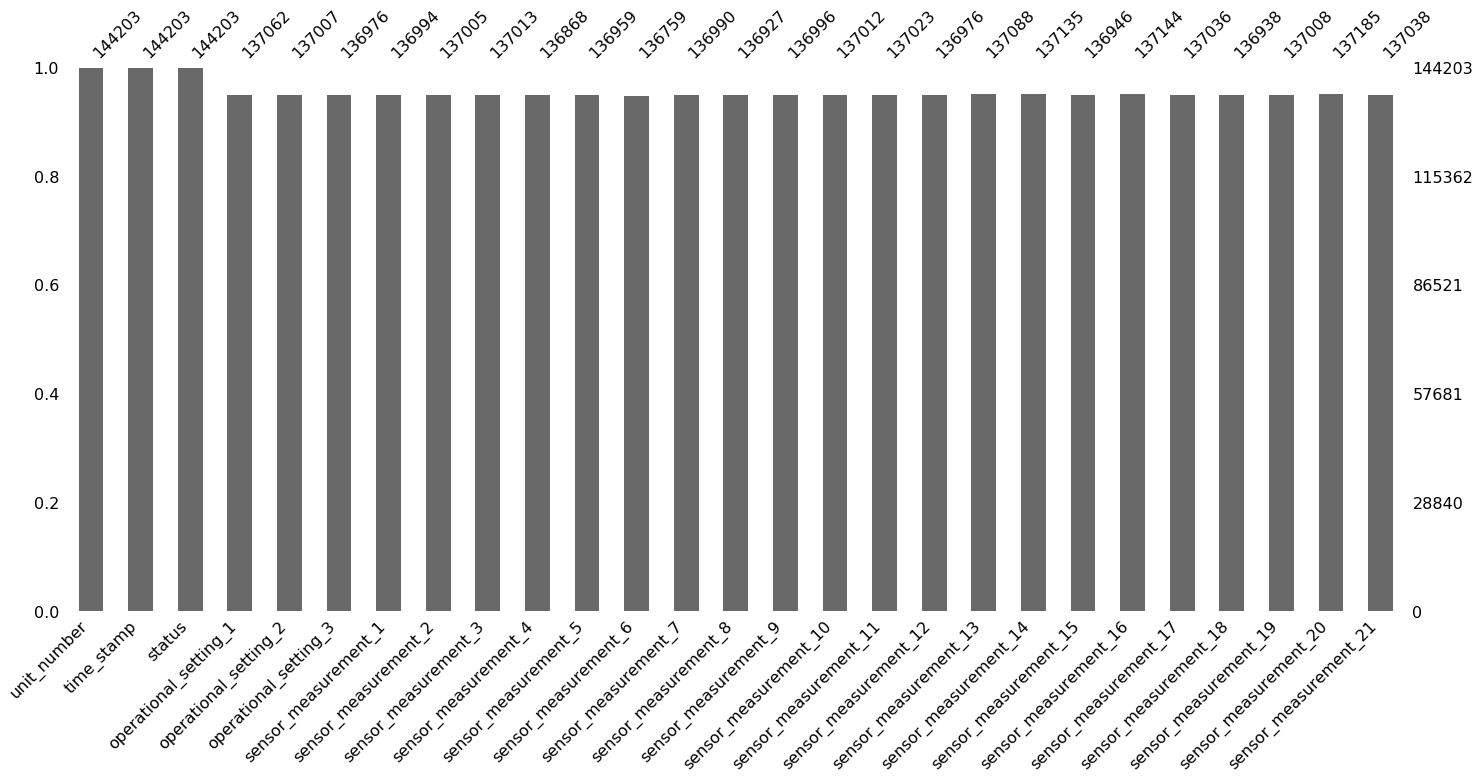

In [6]:
msn.bar(df)

In [7]:
df.iloc[:,3:28].describe()

,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,137062.000000,137007.000000,136994.000000,137005.000000,137013.000000,136868.000000,136959.000000,136759.000000,136990.000000,136927.000000,...,136976.000000,137088.000000,137135.000000,136946.000000,137144.000000,137036.000000,136938.000000,137008.000000,137185.000000,137038.000000
mean,17.075966,0.406348,486.132686,597.771761,1468.144709,1262.295400,9.935961,14.487827,361.227447,2274.757600,...,340.434790,2349.903834,8089.449809,9.049490,0.025226,360.999569,2274.604843,98.402123,26.050472,15.631200
std,16.534306,0.368293,30.435453,42.514419,118.189101,136.348238,4.268740,6.447176,174.309332,142.335384,...,164.371761,110.837314,80.528884,0.751212,0.004995,31.017661,142.432048,4.639714,11.703273,7.022004
min,-0.008700,-0.000600,445.000000,535.480000,1242.980000,1023.770000,3.910000,5.670000,136.170000,1914.720000,...,128.450000,2027.570000,7848.360000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.091800
25%,0.001200,0.000200,449.440000,549.990000,1357.620000,1127.060000,5.480000,8.000000,175.730000,2212.130000,...,164.820000,2387.970000,8070.750000,8.437700,0.020000,332.000000,2212.000000,100.000000,14.340000,8.604525
50%,10.007800,0.251900,491.190000,606.520000,1493.670000,1293.970000,10.520000,15.460000,392.840000,2323.690000,...,370.220000,2388.070000,8119.710000,8.741350,0.030000,368.000000,2324.000000,100.000000,28.250000,16.944950
75%,35.001300,0.840000,518.670000,642.350000,1586.720000,1402.300000,14.620000,21.610000,553.320000,2388.050000,...,521.370000,2388.160000,8139.630000,9.343700,0.030000,392.000000,2388.000000,100.000000,38.830000,23.299000
max,42.008000,0.842000,518.670000,645.110000,1616.910000,1441.160000,14.620000,21.610000,570.810000,2388.640000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.890000,23.950500


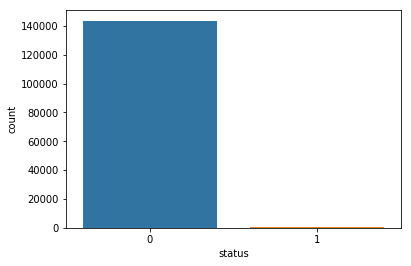

In [8]:
# Explore the status distribution
sns.countplot(x="status", data=df)

In [9]:
# Create label
new_df = create_labels(df)
new_df.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time,label
0,308,2014-01-01 12:00:00,0,41.9996,0.8400,High,445.00,548.98,1348.32,1115.01,...,8078.93,9.3585,0.02,330.0,2212.0,100.0,10.64,6.2918,2014-01-01,0
1,286,2014-01-01 12:00:00,0,20.0058,0.7008,NaN,491.19,606.98,1478.82,1246.69,...,8068.06,NaN,0.02,365.0,2324.0,100.0,24.58,14.7213,2014-01-01,0
2,22,2014-01-01 12:00:00,0,NaN,-0.0003,High,518.67,642.68,1595.65,1408.51,...,8127.45,8.4425,0.03,393.0,2388.0,100.0,38.96,23.3081,2014-01-01,0
3,122,2014-01-01 12:00:00,0,0.0002,0.0000,High,518.67,642.35,NaN,1396.41,...,8136.80,8.3946,0.03,394.0,2388.0,NaN,39.04,NaN,2014-01-01,0
4,360,2014-01-01 12:00:00,0,34.9989,NaN,High,449.44,NaN,1371.34,1121.46,...,8064.58,9.2879,0.02,334.0,2223.0,100.0,14.88,8.9362,2014-01-01,0


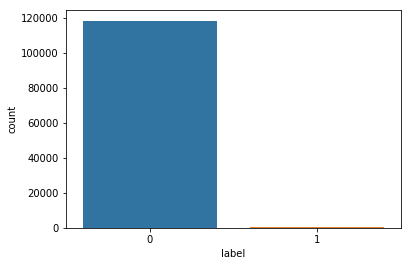

In [10]:
# Explore the label distribution
sns.countplot(x="label", data=new_df)

In [11]:
# Create new column of total date of each wind turbine
new_df["total_date"] = new_df.groupby("unit_number")['time_stamp'].transform(lambda g: g.iloc[-1] - g.iloc[0])
new_df[["time_stamp","unit_number","total_date"]].head()

,time_stamp,unit_number,total_date
0,2014-01-01 12:00:00,308,109 days
1,2014-01-01 12:00:00,286,153 days
2,2014-01-01 12:00:00,22,161 days
3,2014-01-01 12:00:00,122,151 days
4,2014-01-01 12:00:00,360,275 days


Looking at the number of total date for all wind turbine. An average number is around 200 - 250 days for each wind turbine.

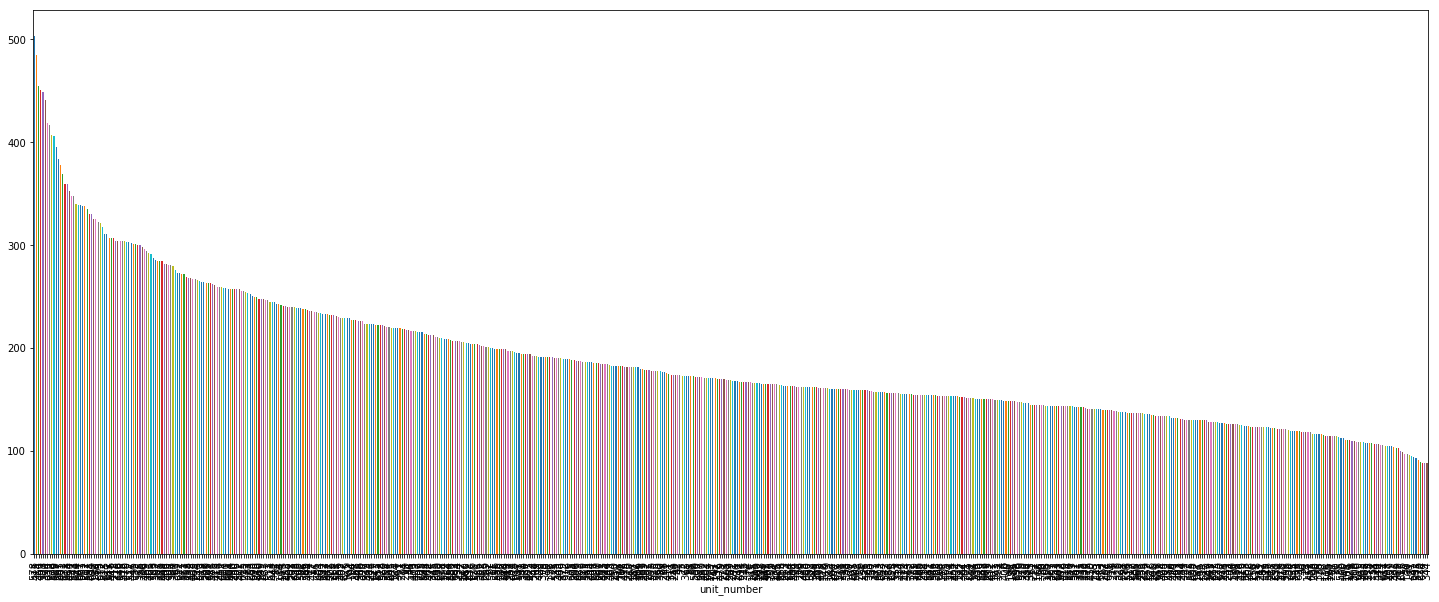

In [12]:
new_df[["time_stamp","unit_number","total_date"]].groupby("unit_number").size().sort_values(ascending=False).plot.bar(figsize=(25, 10))

In [13]:
new_df.shape

(118883, 30)

In [14]:
# Drop all row that has missing value:
wind_turbine = new_df.dropna()
wind_turbine.shape

(34678, 30)

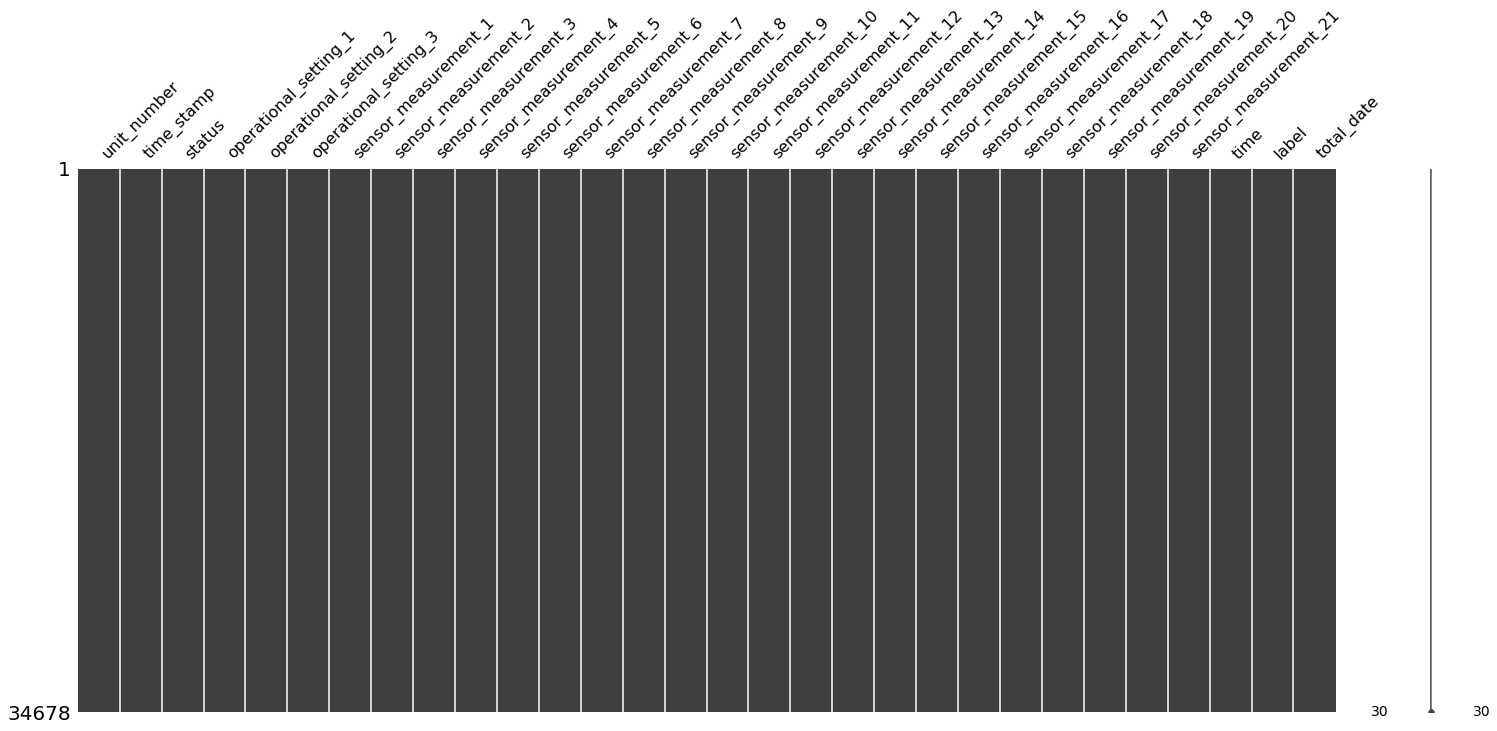

In [15]:
# Check if all NA has been removed:
msn.matrix(wind_turbine)

In [16]:
wind_turbine.groupby("unit_number").count().head()

,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time,label,total_date
unit_number,,,,,,,,,,,,,,,,,,,,,
2,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
3,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41
4,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
5,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
6,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42


In [17]:
# Create a list of features needed
X_col = [ i for i in wind_turbine.columns if i not in ['unit_number', 'time', 'total_date', 'status', 'label']]

In [18]:
# Create X, y
X = wind_turbine[X_col]
y = wind_turbine[["label","time_stamp"]] # keeping time_stamp to split train test validation

In [19]:
# Split Train, Test, Validation set

# For X
Xval = X[X['time_stamp'].dt.year==2018].loc[:, X.columns != "time_stamp"]
Xtest = X[(X['time_stamp'].dt.year < 2018) & (X['time_stamp'].dt.year > 2015)].loc[:,X.columns != "time_stamp"]
Xtrain = X[X['time_stamp'].dt.year<2016].loc[:,X.columns != "time_stamp"]

# For y:
yval = y[y['time_stamp'].dt.year==2018]['label']
ytest = y[(y['time_stamp'].dt.year < 2018) & (y['time_stamp'].dt.year > 2015)]['label']
ytrain = y[y['time_stamp'].dt.year<2016]['label']

In [20]:
Xtrain.head()

,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
6,10.0029,0.2511,High,489.05,604.73,1496.59,1305.02,10.52,15.49,395.29,...,372.20,2388.01,8135.48,8.6057,0.03,366.0,2319.0,100.00,28.74,17.1307
8,25.0071,0.6200,Low,462.54,537.00,1257.79,1046.50,7.05,9.03,175.33,...,164.28,2028.34,7880.20,10.8643,0.02,305.0,1915.0,84.93,14.25,8.6234
13,41.9991,0.8416,High,445.00,548.88,1351.14,1123.82,3.91,5.71,138.92,...,130.47,2387.84,8081.67,9.3457,0.02,329.0,2212.0,100.00,10.67,6.3425
15,24.9981,0.6216,Low,462.54,536.88,1264.02,1054.22,7.05,9.03,176.15,...,164.30,2028.08,7870.69,10.9144,0.02,308.0,1915.0,84.93,14.31,8.5945
17,19.9987,0.7012,High,491.19,607.08,1481.04,1243.92,9.35,13.65,334.84,...,315.28,2388.10,8066.41,9.1915,0.02,364.0,2324.0,100.00,24.49,14.7063


In [21]:
Xtrain.columns == Xtest.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [22]:
Xtrain.columns == Xval.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [33]:
# Transform categorical for upsizing train data
Xtrain["operational_setting_3"] = pd.get_dummies(Xtrain["operational_setting_3"]).iloc[:,0]

In [24]:
# Upsizing the data:
sm = SMOTE(random_state=39)
Xtrain_res, ytrain_res = sm.fit_sample(Xtrain, ytrain)

In [25]:
Xtrain.shape

(16070, 24)

In [26]:
Xtrain_res = pd.DataFrame(Xtrain_res, columns=list(Xtrain.columns.values))
Xtrain_res.head()

,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,10.0029,0.2511,1.0,489.05,604.73,1496.59,1305.02,10.52,15.49,395.29,...,372.20,2388.01,8135.48,8.6057,0.03,366.0,2319.0,100.00,28.74,17.1307
1,25.0071,0.6200,0.0,462.54,537.00,1257.79,1046.50,7.05,9.03,175.33,...,164.28,2028.34,7880.20,10.8643,0.02,305.0,1915.0,84.93,14.25,8.6234
2,41.9991,0.8416,1.0,445.00,548.88,1351.14,1123.82,3.91,5.71,138.92,...,130.47,2387.84,8081.67,9.3457,0.02,329.0,2212.0,100.00,10.67,6.3425
3,24.9981,0.6216,0.0,462.54,536.88,1264.02,1054.22,7.05,9.03,176.15,...,164.30,2028.08,7870.69,10.9144,0.02,308.0,1915.0,84.93,14.31,8.5945
4,19.9987,0.7012,1.0,491.19,607.08,1481.04,1243.92,9.35,13.65,334.84,...,315.28,2388.10,8066.41,9.1915,0.02,364.0,2324.0,100.00,24.49,14.7063


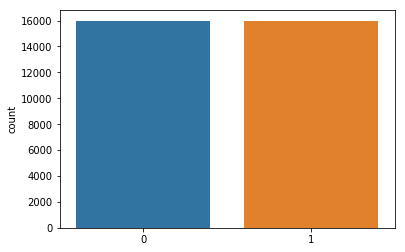

In [27]:
# new distribution of labels:
sns.countplot(x=ytrain_res)

In [28]:
from sklearn.preprocessing import FunctionTransformer

In [29]:
X_col.remove("time_stamp")

In [54]:
?DataFrameMapper

Init signature: DataFrameMapper(features, default=False, sparse=False, df_out=False, input_df=False)
Docstring:     
Map Pandas data frame column subsets to their own
sklearn transformation.
Init docstring:
Params:

features    a list of tuples with features definitions.
            The first element is the pandas column selector. This can
            be a string (for one column) or a list of strings.
            The second element is an object that supports
            sklearn's transform interface, or a list of such objects.
            The third element is optional and, if present, must be
            a dictionary with the options to apply to the
            transformation. Example: {'alias': 'day_of_week'}

default     default transformer to apply to the columns not
            explicitly selected in the mapper. If False (default),
            discard them. If None, pass them through untouched. Any
            other transformer will be applied to all the unselected
            colu

In [62]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer

mapper = DataFrameMapper(['operational_setting_3', LabelBinarizer()], default=None, input_df=True, df_out=True)
mapper.fit(Xtrain)

TypeError: _build_feature() takes from 2 to 3 positional arguments but 21 were given

In [63]:
model = keras_model(n_layers=1, n_feats=Xtrain_res.shape[1])
# pipeline
pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('dataframemapper', DataFrameMapper('operational_setting_3', get_dummies, input_df=True)),
        ('model', model)
    ])

In [31]:
ytrain_res[900:1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
# Fit to the training data
pl.fit(Xtrain_res[900:1000], to_categorical(ytrain_res[900:1000]))

# Compute and print accuracy
# model.evaluate(Xtest, to_categorical(ytest), batch_size=128)

ValueError: not enough values to unpack (expected 3, got 1)

In [45]:
model.predict(Xtest)

ValueError: could not convert string to float: 'High'

In [38]:
# Compute and print accuracy
model.evaluate(Xtrain, to_categorical(ytrain), batch_size=128)

16070/16070 [==============================] - 0s 20us/step


[0.745515162639167, 0.6192906035943735]

In [ ]:
# Fitting general models:
model_list = {"Logistic Regression": LR(),
              "Random Forest Classifier": RFC(),
              "K Nearest Neighbor": KNN()
             }

for k, v in model_list.items():
    print("Fitting {} model...".format(k))
    v.fit(Xtrain_res, ytrain_res)
    print("Train accuracy is:", accuracy_score(ytrain_res, v.predict(Xtrain_res)).round(3))
    ypred = v.predict(Xtest)
    print("Test accuracy is:", accuracy_score(ytest, ypred).round(3))
    print("Confusion Maxtric for {} model".format(k))
    skplt.metrics.plot_confusion_matrix(ytest, ypred)
    plt.show()

In [37]:
get_dummies(Xtrain_res[900:1000])

D:\Job\Code Challenge\Canvas Analytics\Code_Challenge\src\task1\get_dummies.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['operational_setting_3'] = pd.get_dummies(df['operational_setting_3']).iloc[:,0]


,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
900,20.0038,0.7017,0,491.19,607.73,1483.19,1250.27,9.35,13.65,334.64,...,315.20,2388.15,8067.58,9.2646,0.02,365.0,2324.0,100.00,24.60,14.6573
901,0.0005,0.0000,0,518.67,642.76,1585.74,1401.81,14.62,21.58,550.71,...,518.36,2387.30,8116.68,8.4285,0.03,389.0,2388.0,100.00,39.02,23.2804
902,35.0077,0.8401,0,449.44,555.64,1366.77,1129.24,5.48,8.00,194.16,...,183.49,2388.01,8061.91,9.2984,0.02,333.0,2223.0,100.00,14.84,8.8971
903,34.9984,0.8414,0,449.44,555.34,1364.60,1132.08,5.48,8.00,194.49,...,183.71,2388.11,8066.94,9.2958,0.02,336.0,2223.0,100.00,14.81,8.8473
904,0.0006,-0.0003,0,518.67,642.84,1590.81,1415.48,14.62,21.61,553.37,...,521.06,2388.17,8122.24,8.4258,0.03,393.0,2388.0,100.00,38.72,23.2983
905,20.0005,0.7000,0,491.19,607.99,1482.06,1253.60,9.35,13.66,333.80,...,314.82,2388.15,8064.25,9.2565,0.02,365.0,2324.0,100.00,24.35,14.7949
906,0.0018,0.0020,0,518.67,642.64,1592.38,1399.39,14.62,21.61,554.13,...,522.01,2388.07,8151.03,8.4036,0.03,393.0,2388.0,100.00,38.82,23.3155
907,25.0050,0.6200,1,462.54,536.78,1250.65,1039.09,7.05,9.02,175.57,...,164.69,2028.26,7874.91,10.8545,0.02,305.0,1915.0,84.93,14.24,8.6457
908,42.0018,0.8400,0,445.00,549.68,1354.37,1125.46,3.91,5.72,138.83,...,130.74,2388.00,8085.56,9.3278,0.02,329.0,2212.0,100.00,10.66,6.3926
909,41.9983,0.8407,0,445.00,549.87,1350.76,1129.50,3.91,5.72,138.70,...,130.40,2387.82,8083.44,9.4125,0.02,332.0,2212.0,100.00,10.53,6.3854


In [ ]:
import xgboost as xgb

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(n_estimators=10, objective='binary:logistic', seed=123)

# Fit the classifier to the training set
xg_cl.fit(Xtrain, ytrain)

# Predict the labels of the test set: preds
preds = xg_cl.predict(Xtest)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==ytest))/ytest.shape[0]
print("accuracy: %f" % (accuracy))

In [ ]:
# pipeline
pl = Pipeline([
        ('Impute', Imputer()),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)